# Neural nets for BO


Source: https://gdmarmerola.github.io//ts-for-bayesian-optim/

In [1]:
import jax
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from rebayes_mini.methods import gauss_filter
from rebayes_mini.methods import base_filter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_palette("colorblind")

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [576]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [6]:
def ackley_1d(x, y=0):
    out = (-20*jnp.exp(-0.2*jnp.sqrt(0.5*(x**2 + y**2))) 
           - jnp.exp(0.5*(jnp.cos(2*jnp.pi*x) + jnp.cos(2*jnp.pi*y)))
           + jnp.e + 20)
    
    # returning
    return out

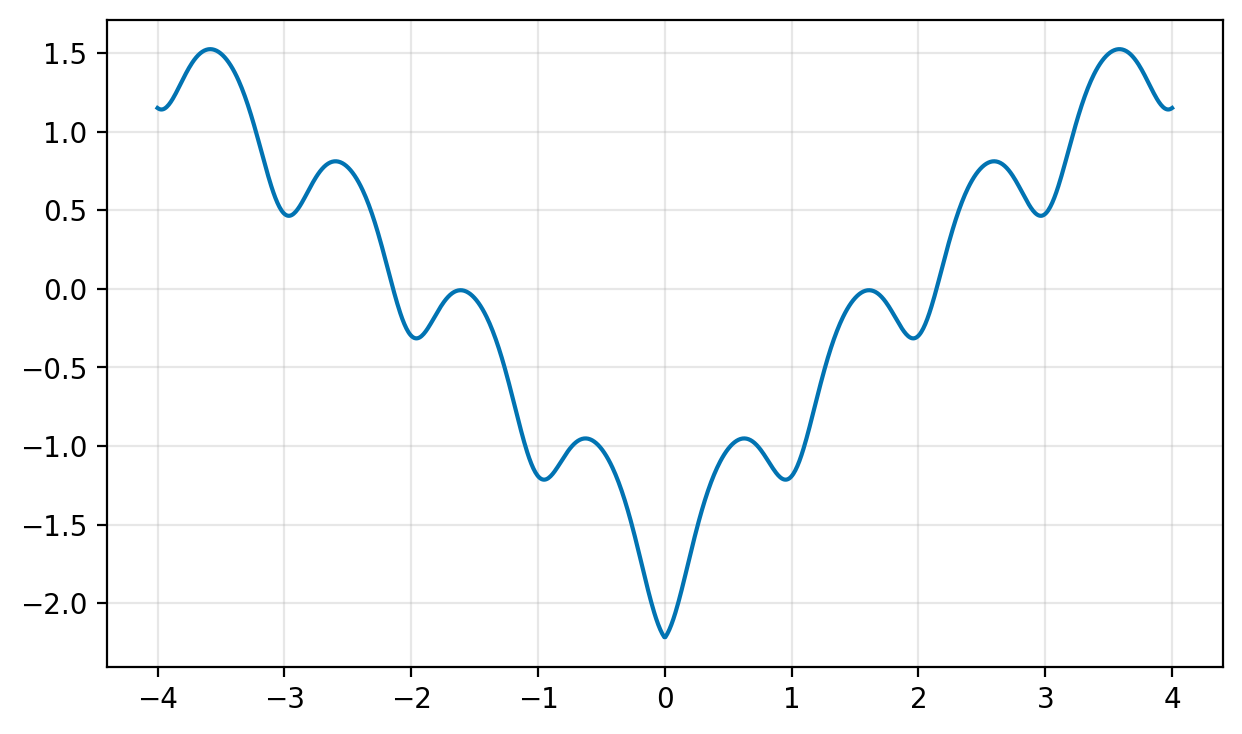

In [7]:
xrange = jnp.linspace(-4, 4, 1000)
yvals = ackley_1d(xrange)
ymean = yvals.mean()
ystd = yvals.std()
yvals = (yvals - ymean) / ystd

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)

## The BNN surrogate model

In [220]:
class MLP(nn.Module):
    n_hidden: int = 20

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [236]:
key = jax.random.PRNGKey(31415)
key_data, key_train, key_sample = jax.random.split(key, 3)

## Training model

In [456]:
x_samples = jax.random.uniform(key_data, shape=(15,1), minval=-4, maxval=4)

In [457]:
y_samples = ackley_1d(x_samples)
y_samples = (y_samples - ymean) / ystd

In [458]:
import numpy as np

In [459]:
def callback(bel_update, bel_pred, y, x, agent):
    Ht = agent.grad_mean(bel_update.mean, x)
    yhat = agent.mean_fn(bel_update.mean, x).astype(float)
    err = y - yhat - Ht @ (bel_pred.mean - bel_update.mean)
    return jnp.abs(err)

In [460]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

# n_params = 1321
# covdyn = jnp.ones(n_params) * 1.0
# covdyn = covdyn.at[-21:].set(0.0)

def cov_fn(y): return 1e-9
agent = base_filter.SquareRootFilter(model.apply, cov_fn, dynamics_covariance=0.0, n_inner=10)
bel_init = agent.init_bel(params_init, cov=1.0)

# replacing last-layer covariance
bel_init = bel_init.replace(W=bel_init.W.at[-21:, -21:].set(jnp.eye(21) * 5.0))

bel, hist = agent.scan(bel_init, y_samples, x_samples, callback)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 19.2 s, sys: 772 ms, total: 19.9 s
Wall time: 3.89 s


In [461]:
hist.squeeze()

array([0.3457, 1.1112, 3.0713, 0.7505, 0.1538, 0.0398, 4.2208, 0.7   , 0.046 , 0.3683, 0.0964, 0.0198, 2.3361, 0.0687, 1.3162], dtype=float32)

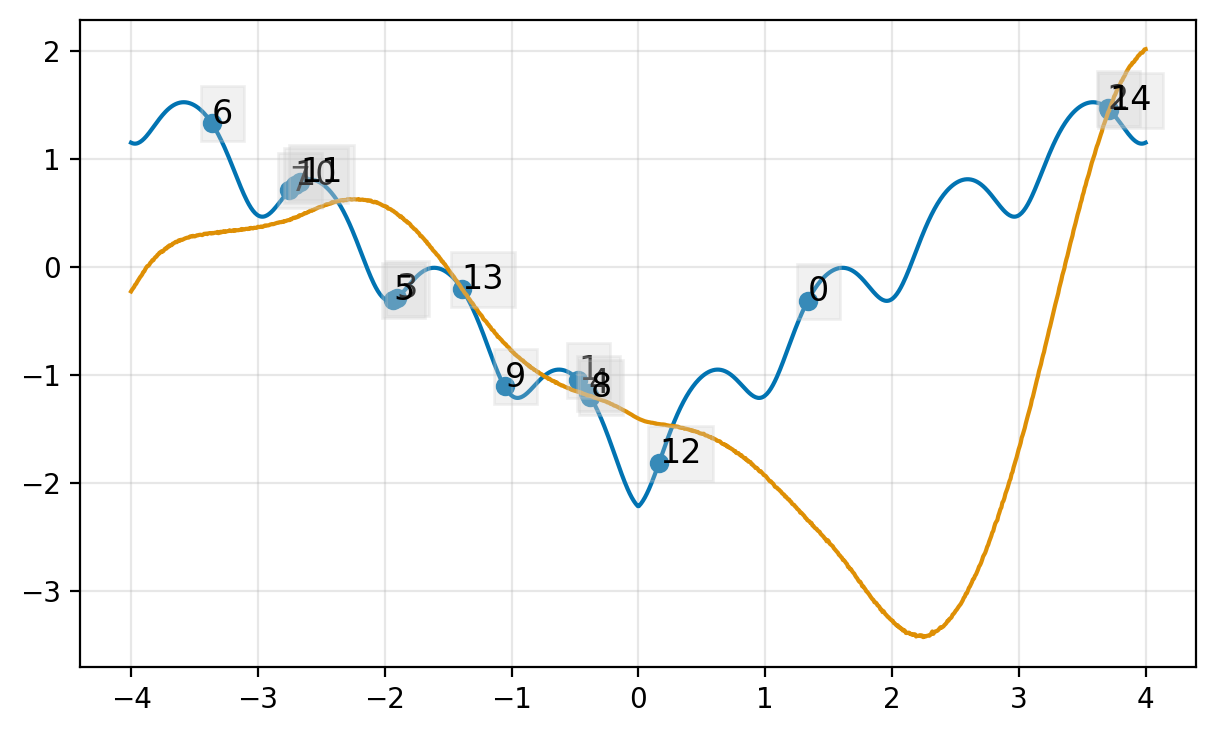

In [462]:
plt.scatter(x_samples, y_samples)

for i, (x, y) in enumerate(zip(x_samples, y_samples)):
    plt.text(x.item(), y.item(), i, fontsize=12, backgroundcolor="#ccc4")

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)
plt.plot(xrange, agent.mean_fn(bel.mean, xrange[:, None]))

## Copy

In [317]:
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (20,), 'kernel': (1, 20)},
  'Dense_1': {'bias': (20,), 'kernel': (20, 20)},
  'Dense_2': {'bias': (20,), 'kernel': (20, 20)},
  'last_layer': {'bias': (1,), 'kernel': (20, 1)}}}

In [318]:
eps = jax.random.normal(key_sample, (100, len(bel.mean)))

In [319]:
sample_params = jnp.einsum("ji,sj->si", bel.W, eps) + bel.mean

In [320]:
eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

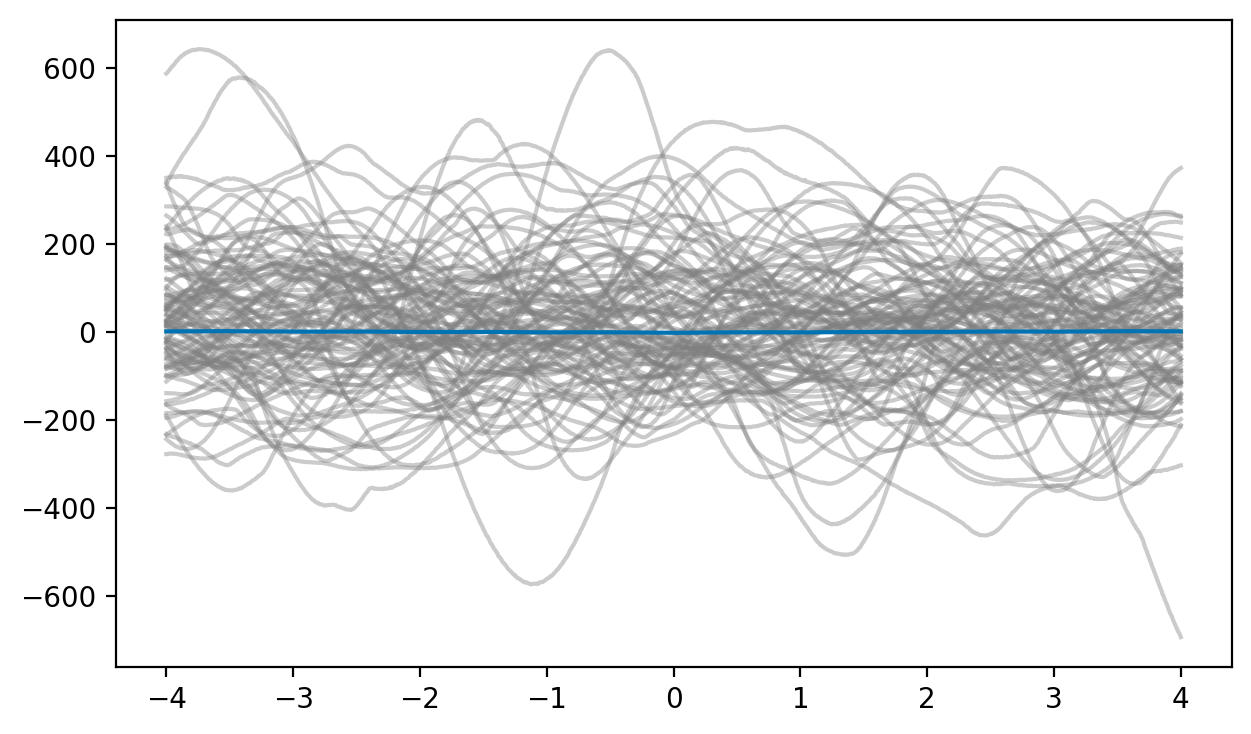

In [321]:
plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals)

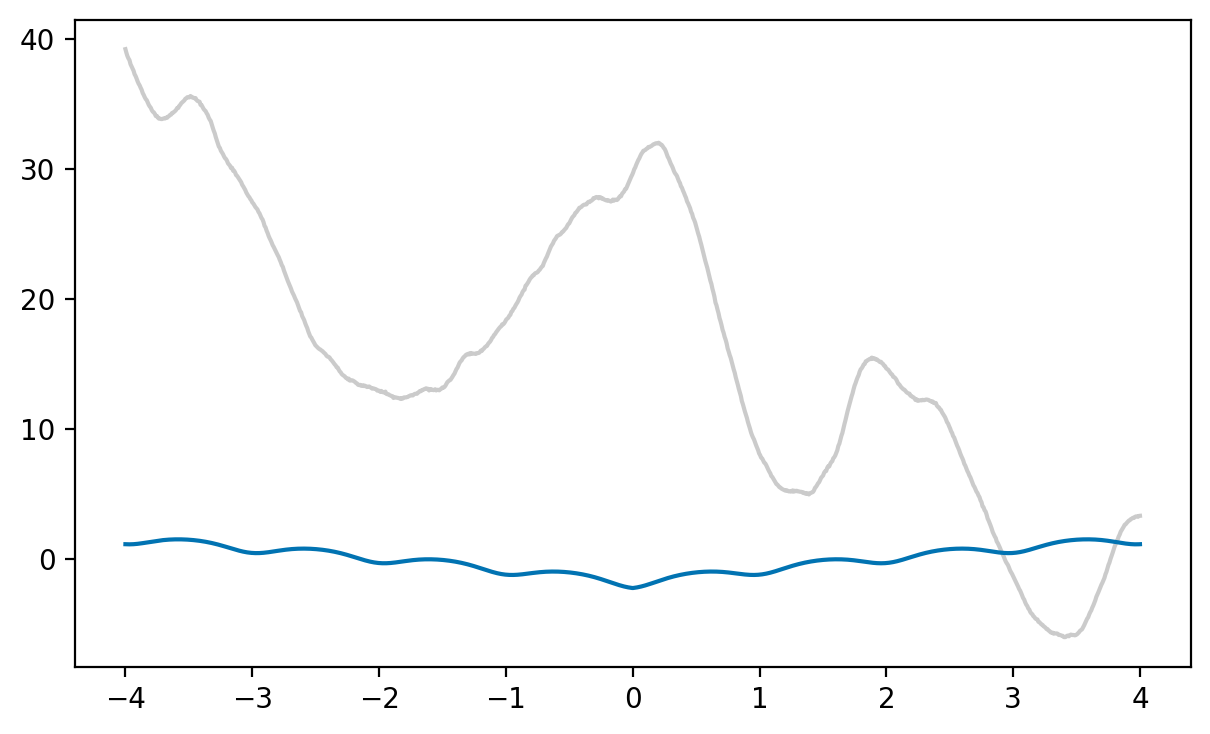

In [322]:
plt.plot(xrange, eval_samples.mean(axis=0), c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals)

## Sampling from last-layer only

In [323]:
from functools import partial

In [324]:
dim_ll = 21
W_ll = bel.W[-dim_ll:, -dim_ll:]
mean_ll = bel.mean[-dim_ll:]

In [325]:
eps = jax.random.normal(key_sample, (15, dim_ll))

In [326]:
mean_hidden = bel.mean[:-dim_ll]

In [327]:
sample_params = jnp.einsum("ji,sj->si", W_ll, eps) + mean_ll

In [328]:
@partial(jax.vmap, in_axes=(0, None, None))
def join_eval(ll_params, hidden_params, x):
    params = jnp.concat([hidden_params, ll_params])
    return agent.mean_fn(params, x).squeeze()

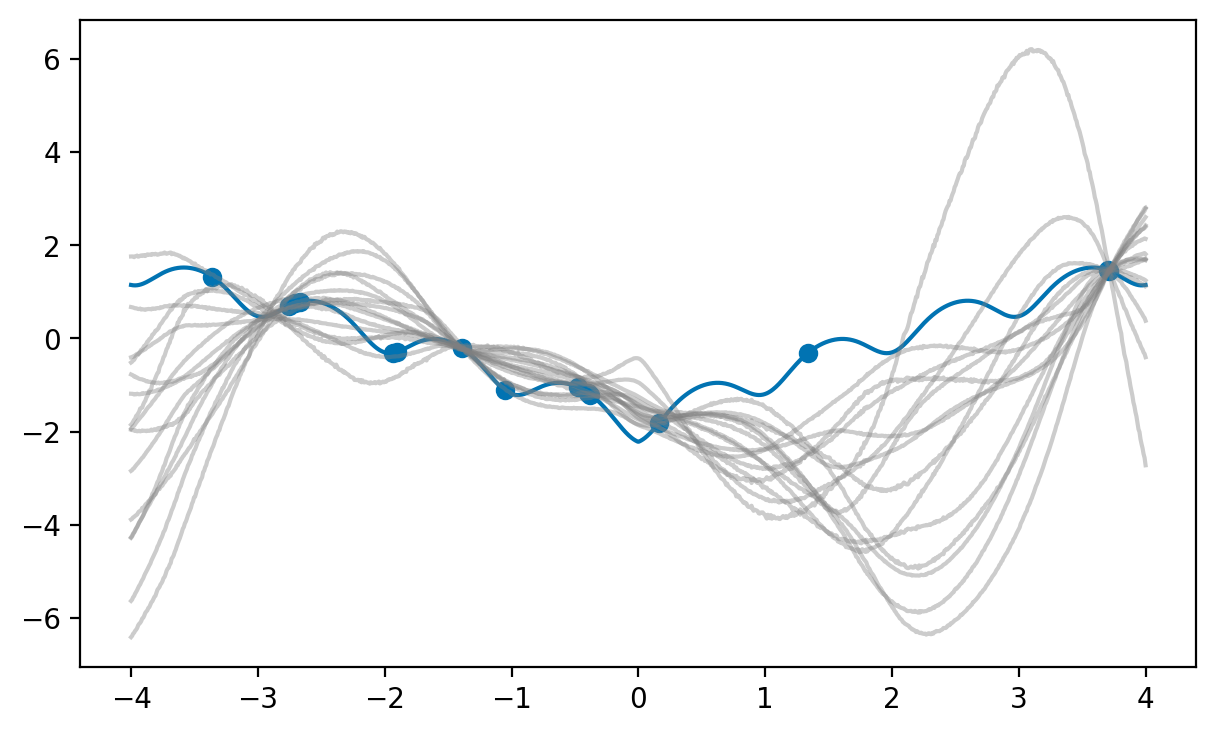

In [329]:
plt.plot(xrange, yvals)
ysamples = join_eval(sample_params, mean_hidden, xrange[:, None])
plt.plot(xrange, ysamples.T, c="gray", alpha=0.4)
plt.scatter(x_samples, y_samples);

# Low-rank last layer

In [330]:
from rebayes_mini.methods import low_rank_last_layer as olli

In [828]:
x_samples = jax.random.uniform(key_data, shape=(12,1), minval=-4, maxval=4)

In [829]:
y_samples = ackley_1d(x_samples)
y_samples = (y_samples - ymean) / ystd

In [830]:
def callback(bel_update, bel_prior, y, x, agent):
    yhat = agent.mean_fn(bel_update.mean_hidden, bel_update.mean_last, x)
    R_half = jnp.linalg.cholesky(jnp.atleast_2d(agent.covariance(yhat)), upper=True)
    # Jacobian for hidden and last layer
    J_hidden = agent.jac_hidden(bel_update.mean_hidden, bel_update.mean_last, x)
    J_last = agent.jac_last(bel_update.mean_hidden, bel_update.mean_last, x)

    # Innovation
    err = y - yhat - J_hidden @ (bel_prior.mean_hidden - bel_update.mean_hidden) - J_last @ (bel_prior.mean_last - bel_update.mean_last)

    return jnp.abs(err)

In [831]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
# agent = olli.LowRankLastLayer(
#     model.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
# )
agent = olli.LowRankLastLayerIt(
    model.apply, cov_fn, rank=200, dynamics_hidden=0.0, dynamics_last=1e-5,
    n_it_hidden=1, n_it_last=1
)
# bel_init = agent.init_bel(params_init, cov_hidden=1e-3, cov_last=2.0)
bel_init = agent.init_bel(params_init, cov_hidden=6e-3, cov_last=3.0)

cfn = partial(callback, agent=agent)
bel, hist = agent.scan(bel_init, y_samples, x_samples, cfn)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 2.59 s, sys: 52.7 ms, total: 2.64 s
Wall time: 1.52 s


In [832]:
hist.squeeze()

array([0.3455 , 1.08026, 2.67317, 0.25186, 0.16395, 0.0255 , 4.35011, 0.74051, 0.00905, 1.2406 , 0.16925, 0.20076], dtype=float32)

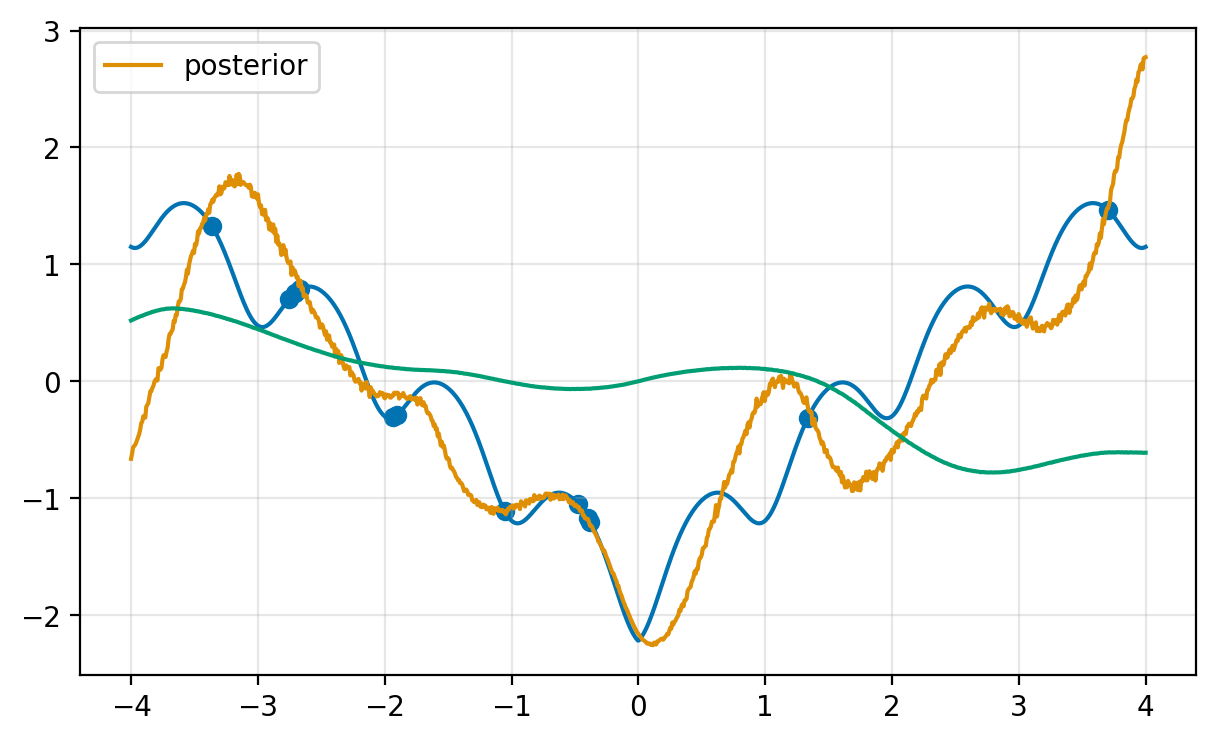

In [833]:
plt.scatter(x_samples, y_samples)

plt.plot(xrange, yvals)
plt.plot(xrange, agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]), label="posterior")
plt.plot(xrange, agent.mean_fn(bel_init.mean_hidden, bel_init.mean_last, xrange[:, None]))
plt.legend()
plt.grid(alpha=0.3)

In [834]:
eps = jax.random.normal(key_sample, (15, len(bel.mean_last)))

In [835]:
sample_params = jnp.einsum("ji,sj->si", bel.loading_last, eps) + bel.mean_last

In [836]:
@partial(jax.vmap, in_axes=(0, None, None))
def join_eval(ll_params, hidden_params, x):
    return agent.mean_fn(hidden_params,ll_params, x).squeeze()

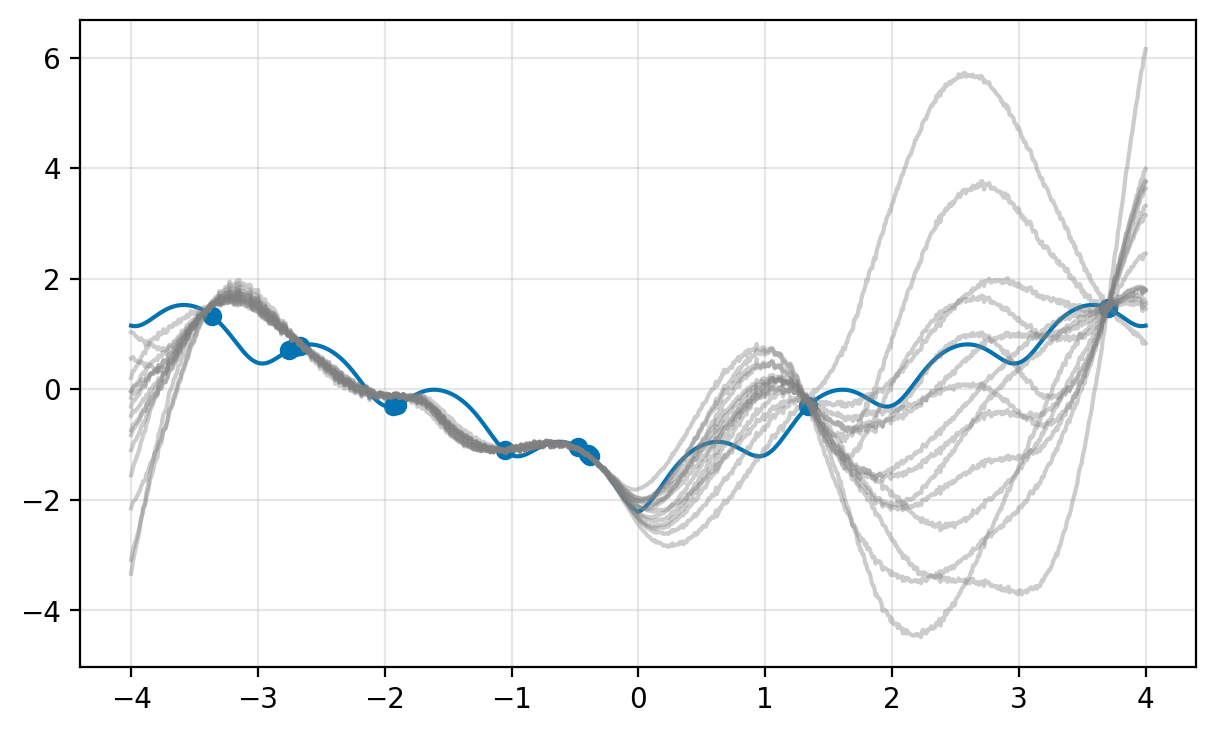

In [837]:
plt.plot(xrange, yvals)
ysamples = join_eval(sample_params, bel.mean_hidden, xrange[:, None])
plt.plot(xrange, ysamples.T, c="gray", alpha=0.4)
plt.scatter(x_samples, y_samples)
plt.grid(alpha=0.3)